# <center> Lecture13 : Logistic Regression </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## 引入  

* 在lec12中，我们介绍了适用于因变量为计数数据的泊松回归模型与负二项回归模型。  

* 在本节课中，我们则关注当**因变量为二分变量(例如性别、反应是否正确)**时适用的回归模型——logistic回归模型

**研究问题**  

本节课中我们关注的研究问题：**个体依恋风格中的回避倾向**如何影响个体的**恋爱情况**？  

* 成人依恋量表是一种常用于评估个体依恋风格的工具，包括亲密关系中的情感需求和行为模式。其中的回避分数反映了个体在恋爱关系中表现出的回避特征。这些特征通常表现为对亲密关系的回避、不愿意与伴侣建立过多的情感联系、保持独立性和独立思考的倾向。  

* 研究假设：具有高回避分数的个体可能更倾向于避免或抵制与伴侣建立深入的情感联系，更难以建立恋爱关系  

* 在此示例研究中，我们使用成人依恋量表中的分量表测得回避分数，并使用标准化后的回避分数进行后续分析。  

> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3  
> * 回避分数量表来源：Fraley, R. C., Waller, N. G. & Brennan, K. A. An item response theory analysis of self-report measures of adult attachment. J. Pers. Soc. Psychol. 78, 350–365 (2000).

In [2]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [410]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')


# 选取METU站点的数据
df = df_raw[df_raw["Site"] == "METU"]

# 选取涉及的变量
df = df[["romantic", "anxiety", "smoke", "sex", "avoidance_r"]]

#重新编码，编码后的数据：1 = "yes"; 2 = "no"
df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)

#设置索引
df["index"] = range(len(df))
df = df.set_index("index")

In [411]:
df.isnull().values.any()

False

In [412]:
df

,romantic,anxiety,smoke,sex,avoidance_r
index,,,,,
0,1,2.666667,2.0,1.0,-0.303495
1,0,3.944444,1.0,2.0,-1.131624
2,1,4.388889,2.0,2.0,0.469426
3,0,4.777778,2.0,2.0,0.082965
4,1,3.000000,2.0,2.0,1.407973
...,...,...,...,...,...
176,0,4.388889,2.0,2.0,-1.131624
177,1,4.166667,2.0,2.0,2.456937
178,1,4.277778,2.0,2.0,-0.910790


**🤔思考：当自变量增加或减少时因变量如何变化？**  

我们观测一下数据。  
- 因变量“恋爱情况(romantic)”为二元变量，其中 1代表“已经恋爱”，0代表“没有恋爱”。  
- 自变量“回避倾向(avoidance_r)”为连续变量，并且经过标准化。  

可以发现，随着自变量增加，因变量的取值都是 0 或 1，因此，如何发现自变量对因变量的影响？

In [413]:
# 展示数据
df.head(10)

,romantic,anxiety,smoke,sex,avoidance_r
index,,,,,
0,1,2.666667,2.0,1.0,-0.303495
1,0,3.944444,1.0,2.0,-1.131624
2,1,4.388889,2.0,2.0,0.469426
3,0,4.777778,2.0,2.0,0.082965
4,1,3.000000,2.0,2.0,1.407973
5,1,4.500000,1.0,2.0,1.076721
6,1,2.555556,1.0,1.0,0.524635
7,1,3.555556,1.0,2.0,1.960059
8,0,4.444444,2.0,2.0,-0.137869


In [414]:
# 因变量分布
plt.hist(df["romantic"])
plt.xticks([0,1])
plt.xlabel("romantic")
plt.ylabel("count")
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

In [415]:
# 绘制散点图
sns.scatterplot(data=df,
                x="avoidance_r",
                y="romantic",
                alpha=0.6)
# 设置x轴标题
plt.xlabel("avoidance")
# 设置y轴刻度
plt.yticks([0,1],['no','yes'])
sns.despine()

<Figure size 640x480 with 1 Axes>

## 选择合适的分布  

* 🤔我们应该为二元变量$Y_i$选择哪一种分布？  

   a. Bernoulli  

   b. Gamma  

   c. Beta  


**Gamma分布与Beta分布**  

   * 在lec3中，我们介绍了Beta分布，用来模拟周王的支持率$\pi$，$\pi$的取值范围满足[0,1]  

   * 在lec5中，我们介绍了Gamma分布，用以模拟中国每天获得奖牌的平均数量$\lambda$ ，$\lambda$ 是一个可以取任何正值的连续变量  

<table>  
	<tr>  
            <td>Beta分布</td>  
					<td><img src="https://cdn.kesci.com/upload/s50phv2jbg.png?imageView2/0/w/960/h/960" alt="" width="200" height="150"> </td>  
   </tr>  
   <tr>  
            <td>Gamma分布</td>  
					<td><img src="https://cdn.kesci.com/upload/s50pi6t34t.png?imageView2/0/w/960/h/960" alt="" width="200" height="150"> </td>  
   </tr>  
</table>  

### 伯努利(Bernoulli)分布  


由于 $Y_i$ 是一个离散变量，只有两个取值：0或1，可知Gamma分布与Beta分布都不是合适的分布  

更加适合变量 $Y_i$ 的分布为伯努利(Bernoulli)分布，该分布只有两个取值0或1。

**伯努利试验**  

要了解伯努利分布，我们需要知道伯努利试验。  
我们使用抛硬币的例子来演示伯努利试验。  

* 假设我们抛一枚硬币，而该硬币正面朝上的概率是p  
* 那么抛一枚硬币的结果要不是正面朝上(1)，要不就是反面朝上(0)；  
* 其中正面朝上发生的概率是p，反面朝上发生的概率是1=p  

用公式表示为：  

$$  
f(x) = \left\{\begin{matrix} p & if \: x = 1\\  1 - p & if \: x = 0 \end{matrix}\right. \;\;\; \text{ for } x \in \{ 0,1\} ,\;\;\;0 \leq p  \leq 1  
$$

我们可以使用`np.random.binomial`来模拟一次伯努利实验的结果

In [416]:
result = np.random.binomial(n=1, p=0.7, size=1)
print(f"硬币朝向为：{result}")

硬币朝向为：[0]


**伯努利分布**  

* 伯努利分布常常用于描述一次单独的二元实验，例如投硬币的结果  

* 如果随机变量 $X$ 服从伯努利分布，可以表示为 $X \sim \text{Bernoulli}(p)$，其中 $p$ 是成功的概率  

* 伯努利分布的概率质量函数为：  

    * 其中，X是伯努利随机变量，x是取值为0或1的观察值，p是成功的概率。这个函数表示了在一次伯努利试验中，观察到特定取值x的概率。  

$$  
P(X = x) = p^x  (1 - p)^{(1 - x)}\;\;\; \text{ for } x \in \{ 0,1\}  
$$  





<Figure size 640x480 with 1 Axes>
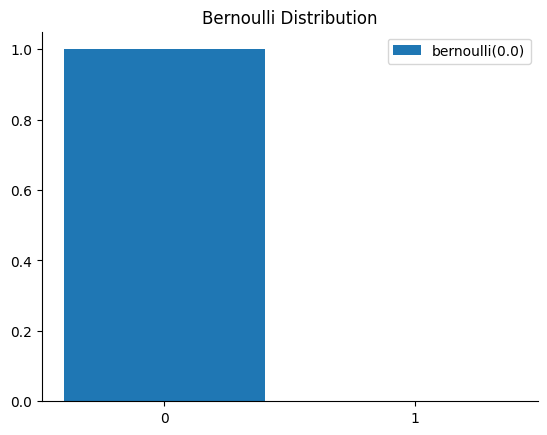

In [417]:
# 定义伯努利分布的绘图函数
def plot_bernoulli():

    def bernoulli(p):
        x = [0,1]
        plt.bar(x, st.bernoulli.pmf(x, p), label=f'bernoulli({p})')
        plt.xticks([0, 1])
        sns.despine()
        plt.title("Bernoulli Distribution")
        plt.legend()

    # 使用 ipywidgets 进行交互式绘图
    ipywidgets.interact(bernoulli, p=(0,1,0.1))
    plt.show()

plot_bernoulli()

**补充知识：伯努利分布与二项分布的关系**  

伯努利分布是一个离散型概率分布，它描述了一次试验的结果只有两种可能性的情况，比如成功和失败、是和非等。伯努利分布由一个参数p控制，表示成功的概率。记作X ~ Bernoulli(p)，其中X为随机变量，p为成功的概率。  

二项分布是一种离散型概率分布，它描述了在n次相互独立的伯努利试验中，成功次数的概率分布，记作X ~ Binomial(n, p)。其中X为随机变量，n为试验次数，p为每次实验成功的概率。  

* 假设我们进行了10次硬币的投掷，每次投掷的结果只有两种可能，正面或反面。每次投掷正面朝上的概率是p。  

* 每次投掷的结果服从伯努利分布。  

* 10次投掷中，正面朝上可能为 0，1，2，3，...，10。正面朝上次数服从的概率分布为二项分布。  


| 分布     | 描述                           | 参数                    | 随机变量    |  
|---------|------------------------------|-----------------------|------------|  
| 伯努利分布 | 描述一次试验的结果只有两种可能性   | 成功概率 p              | X ~ Bernoulli(p) |  
| 二项分布  | 描述在 n 次独立的伯努利试验中成功次数的概率分布 | 试验次数 n, 成功概率 p | X ~ Binomial(n, p) |

In [418]:
# 定义绘制二项分布的函数
def plot_binomial(n,p):

  x = np.arange(0, n+1, 1)
  plt.plot(x, st.binom(n,p).pmf(x), label=f'binomial({p})')

  plt.legend()
  plt.show()

plot_binomial(10,0.5)

<Figure size 640x480 with 1 Axes>

**使用伯努利概率模型来拟合因变量**  

可以从上图发现，伯努利分布和数据因变量分布类似，因此，我们可以尝试使用伯努利分布来描述恋爱情况的分布。  

* 我们使用伯努利概率模型来拟合事件 Y 的取值，其中 $\pi_i$ 表示事件 Y 发生的可能性   $Y_i | \pi_i \sim Bern(\pi_i)$  

* 事件 Y 发生的均值与 $\pi_i$ 相等  $E(Y_i|\pi_i) = \pi_i$  


## Odds & probability  

在为因变量选择合适的分布后，我们需要考虑自变量与因变量的线性关系  

* 在观察数据时，可以发现，由于因变量的取值仅为0或1，我们难以描述因变量随着自变量增加发生的变化。  

* 为了建立自变量与因变量的线性模型，我们需要引入概念：**概率**和**发生比(odds)**

### 概率(probability)  

当不考虑自变量时，因变量“恋爱情况”为““是”的概率为 0.374”  

当考虑自变量“回避倾向”时：  

* 首先，我们将回避倾向分为2个部分  
  * 当“回避倾向”<0，“恋爱情况”为“是”的概率为 0.409;  
  * 当“回避倾向”>0，“恋爱情况”为“是”的概率为0.337  
  
* 似乎，随着回避倾向的增加，恋爱的概率降低  

* 然后，我们可以尝试将回避倾向分为3个部分  
  * 当“回避倾向”<-0.5，已经恋爱的概率为0.448  
  * 当“回避倾向”在[-0.5,0.5]，已经恋爱的概率为0.273  
  * 当“回避倾向”>0.5，已经恋爱的概率为0.393  

* 🙋‍♀️我们可以借助概率的变化来描述自变量与因变量之间的关系

In [419]:
print(f"因变量“恋爱情况”为“是”的概率为{df.romantic.mean():.3f}")

因变量“恋爱情况”为“是”的概率为0.569


In [420]:
print(f"当“回避倾向”<0，“恋爱情况”为“是”的概率为{df[df.avoidance_r<0].romantic.mean():.3f}")
print(f"当“回避倾向”>0，“恋爱情况”为“是”的概率为{df[df.avoidance_r>0].romantic.mean():.3f}")

当“回避倾向”<0，“恋爱情况”为“是”的概率为0.531
当“回避倾向”>0，“恋爱情况”为“是”的概率为0.614


In [421]:
print(f"当“回避倾向”<-0.5，“是”的概率为{df[df.avoidance_r<-0.5].romantic.mean():.3f}")
print(f"当“回避倾向”在[-0.5,0.5]，“是”的概率为{df[(df.avoidance_r >=-0.5) & (df.avoidance_r <=0.5)].romantic.mean():.3f}")
print(f"当“回避倾向”>0.5，“是”的概率为{df[df.avoidance_r>0.5].romantic.mean():.3f}")

当“回避倾向”<-0.5，“是”的概率为0.457
当“回避倾向”在[-0.5,0.5]，“是”的概率为0.679
当“回避倾向”>0.5，“是”的概率为0.603


**伯努利分布、真实数据、与线性关系**  

* 曲线上的每一个点，都服从伯努利分布 $Y_i | \pi_i \sim \text{Bern}(\pi_i)$  

* 当回避倾向较小时，恋爱情况为“是”的概率更高，在真实数据中更可能出现“1”  

* 然而如图所示，曲线代表的是$\pi_i$与自变量$X$之间的关系，二者的关系并不是线性的，因此我们需要对因变量进行一定转换，建立线性关系  

![Image Name](https://cdn.kesci.com/upload/s51rjqo7jp.png?imageView2/0/w/640/h/640)  

**发生率(odds)**  

在这个例子中，$\pi$为因变量$Y$发生的概率  
* 发生比(odds)的定义为：**事件发生概率**与 **事件不发生概率**之比  

$$  
\begin{equation}  
\text{odds} = \frac{\pi}{1-\pi} \;\;,\;\;\;  
\pi = \frac{\text{odds}}{1 + \text{odds}}  
\end{equation}  
$$  

* 比如，明天下雨发生的概率是$\pi = 2/3$，则明天不下雨的概率为$1 - \pi = 1/3$  

    * 在这个例子中，发生比为2，明天下雨的可能性是不下雨可能性的两倍  
    
    * $\pi$的值在$(0,1)$之间，odds的范围则可以是$(0,+\infty)$  
$$  
\text{odds of rain } = \frac{2/3}{1-2/3} = 2  
$$  



事件的发生概率$\pi \in [0,1]$，事件对应的发生比为$\;\;\;\pi / (1-\pi) \in [0, \infty)$  

> 将发生比与1进行比较来衡量事件发生的不确定性：  

1. 当事件发生的概率$\pi < 0.5$时，事件的发生比小于1  

2. 当事件发生的概率$\pi = 0.5$时，事件的发生比为等于1  

3. 当事件发生的概率$\pi > 0.5$时，事件的发生比为大于1

## 选择连接函数(link function)  

* 现在我们可以借助 回答为“是”的概率，以及回答为“是”的发生比，来对回避倾向和恋爱情况建立线性关系  

* 由于恋爱情况是一个二分变量，我们使用 logistic回归模型，它是广义线性模型中的一种  

* 在广义线性模型中，我们需要找到一个连接函数$g(\cdot)$，使得参数g($\pi_i$)可以被表示为自变量$X_{i1}$的线性组合  

    * 🤔以下哪一个是合理的连接函数？  

    1. $\pi_i = \beta_0 + \beta_1 X_{i1}$  

    2.  $\log(\pi_i) = \beta_0 + \beta_1 X_{i1}$  

    3.  $\text{odds}_i = \beta_0 + \beta_1 X_{i1}$  

    4.  $\log(\text{odds}_i) = \beta_0 + \beta_1 X_{i1}$  

* 我们可以比较等式左右两边的取值范围是否一致，并将上述连接函数进行可视化  

| 等式左边    | 取值范围     | 等式右边      | 取值范围    |   
| -------- | ----------------- | ---------------- | ------------------ |  
| $\pi_i$  |  $(0,1)$    | $\beta_0 + \beta_1 X_{i1}$  | $(-\infty, +\infty)$  |  
| $\log(\pi_i)$  |  $(-\infty,0)$     | $\beta_0 + \beta_1 X_{i1}$  | $(-\infty, +\infty)$   |  
| ${odds}_i$  |  $(0,+\infty)$    | $\beta_0 + \beta_1 X_{i1}$  | $(-\infty, +\infty)$   |  
| $\log({odds}_i)$  |$(-\infty, -+\infty)$  | $\beta_0 + \beta_1 X_{i1}$  | $(-\infty, +\infty)$   |  

![Image Name](https://cdn.kesci.com/upload/s50t4pi0jo.png?imageView2/0/w/960/h/960)  


### 公式中各参数的意义  

$$  
\log(\text{odds}) = \log\left(\frac{\pi}{1-\pi}\right) = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p  
$$  

也可以写成：$\text{odds} = e^{\beta_0 + \beta_1 X_{1} +\cdots + \beta_p X_p}$  

* $\beta_0$  

    * 当$(X_1,X_2,\ldots,X_p) = 0$时，$\text{odds} = e^{\beta_0}$，即$e^{\beta_0}$表示当所有自变量为0时，事件的发生比  

* $\beta_1$  

    * $\beta_1 = \log(\text{odds}_{x+1}) - \log(\text{odds}_x)\;\;\;$ → $\;\;\; e^{\beta_1} = \frac{\text{odds}_{x+1}}{\text{odds}_x}$  

    * 当其他自变量保持不变时，$X_1$每增加一个单位（从$x$ → $x+1$），$e^{\beta_1}$表示事件发生比的倍数变化  




* 计算  

    $\log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{i1}\;\;\;$ →  $\;\;\;\frac{\pi_i}{1-\pi_i} = e^{\beta_0 + \beta_1 X_{i1}}\;\;\;$ →  $\;\;\;\pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}}}{1 + e^{\beta_0 + \beta_1 X_{i1}}}$  

## 模型定义  

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_1 & \stackrel{ind}{\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}}}{1 + e^{\beta_0 + \beta_1 X_{i1}}} \\  
\text{priors:} & & \beta_{0}  &  \sim N\left(0, 0.5^2 \right)  \\  
               & & \beta_1  & \sim N\left(0, 0.5^2 \right)\\  
\end{array}  
$$

In [422]:
with pm.Model() as log_model1:
    # 此处对coords的定义方式进行了更改，因为后续我们需要进行对新数据的预测
    # 因此将维度定义成可更改的
    log_model1.add_coord('obs_id',df.index, mutable=True)
    avoidance = pm.MutableData("avoidance", df.avoidance_r, dims="obs_id")
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')

    #先验
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)           #定义beta_1
    #线性关系
    mu = pm.Deterministic("mu", beta_0 + beta_1 * avoidance, dims="obs_id")
    #注意此处使用了Logistic sigmoid function：pm.math.invlogit
    #相当于进行了如下计算 (1 / (1 + exp(-mu))
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")

In [423]:
# 可视化模型（贝叶斯变量因果图）
# 我们使用 pymc 自带的 `model_to_graphviz` 方法来可视化模型中各变量的因果关系。
pm.model_to_graphviz(log_model1)

### 先验预测检验  

使用`pm.sample_prior_predictive`进行先验预测检验，来查看由当前先验组合生成的$\pi$是否都在$(0-1)$范围内  


In [424]:
log1_prior = pm.sample_prior_predictive(samples=50, 
                                          model=log_model1,
                                          random_seed=84735) #看y_est值范围,比较y值

Sampling: [beta_0, beta_1, y_est]


* 在模型定义中我们已经对`pi`进行定义，因此`pm.sample_prior_predictive`就会自动生成对`pi`的预测  

* 该预测储存在`prior`中  

* 我们设置抽样数为50，这体现在维度`draw`中  

* 结合循环，使用`sns.lineplot`绘制出每个回避分数对应的$\pi$值并连接成光滑的曲线

In [425]:
log1_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [426]:
#对于一次抽样，可以绘制出一条曲线，结合循环绘制出50条曲线
for i in range(log1_prior.prior.dims["draw"]):
    sns.lineplot(x = log1_prior.constant_data["avoidance"],
                y = log1_prior.prior["pi"].stack(sample=("chain", "draw"))[:,i], c="grey" )
#设置x、y轴标题和总标题    
plt.xlabel("avoidance",
           fontsize=12)
plt.ylabel("probability of romantic",
           fontsize=12)
plt.suptitle("Relationships between avoidence and the probability of romantic",
           fontsize=14)
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

## MCMC采样 & 模型诊断

In [427]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with log_model1:
    # MCMC 近似后验分布
    log_model1_trace = pm.sample(
                                draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.


In [428]:
az.plot_trace(log_model1_trace,
              var_names=["beta_0","beta_1"],
              figsize=(15,8),
              compact=False)
plt.show()

<Figure size 1500x800 with 4 Axes>

### 后验参数解释  

以下的结果显示：  
- $\beta_0 = -0.48$，那么 $e^{\beta_0} = 0.63$， 表明 X1 为 0时，个体恋爱的可能性为 0.63。  
- $\beta_1 = -0.16$， $e^{\beta_0} = 0.86$， 表明回避分数每增加1个单位，个体恋爱的发生比变为之前的0.86倍。  
- 然而，$\beta_1$ 的94%HDI包括0，说明回避分数不能有效预测恋爱发生的概率。 

In [429]:
az.summary(log_model1_trace, var_names=["beta_0","beta_1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.262,0.146,-0.011,0.539,0.001,0.001,21660.0,14241.0,1.0
beta_1,0.250,0.147,-0.023,0.528,0.001,0.001,20556.0,15082.0,1.0


In [430]:
# 通过 np.exp 将 beta 参数进行转换
az.plot_posterior(log_model1_trace, var_names=["beta_0","beta_1"], transform = np.exp)
plt.show()

<Figure size 1472x552 with 2 Axes>

## 后验回归模型  

### 绘制后验预测回归线  

* 和先验预测模型类似的，通过MCMC采样，也同样生成了对$\pi$的估计，储存在`posterior`中  

* 有4条马尔科夫链，每条链上的采样数为5000，所以对于每一个x，都生成了20000个预测值$\pi$，这样就对应着20000条后验预测回归线  

* 这里我们只需要画出100条即可

In [431]:
log_model1_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [432]:
#对于一次抽样，可以绘制出一条曲线，结合循环绘制出50条曲线
for i in range(100):
    sns.lineplot(x = log_model1_trace.constant_data["avoidance"],
            y = log_model1_trace.posterior["pi"].stack(sample=("chain", "draw"))[:,i], 
            c="grey",
            alpha=0.4)
#设置x、y轴标题和总标题    
plt.xlabel("avoidance",
           fontsize=12)
plt.ylabel("probability of romantic",
           fontsize=12)
plt.suptitle("100 posterior plausible models",
           fontsize=14)
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

#### 使用`az.plot_hdi`进行绘图  
* 或者我们也可以借助`az.plot_hdi`，画出每个自变量对应的恋爱概率$\pi$94%hdi值

In [433]:
#画出每个自变量对应的恋爱概率94%hdi值
az.plot_hdi(
    df.avoidance_r,
    log_model1_trace.posterior.pi,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1"
)
#得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
post_mean = log_model1_trace.posterior.pi.mean(("chain", "draw"))
sns.lineplot(x = df.avoidance_r, 
             y= post_mean, 
             label="posterior mean", 
             color="C1")
#绘制真实数据散点图
sns.scatterplot(x = df.avoidance_r, 
                y= df.romantic,label="observed data", 
                color='#C00000', 
                alpha=0.5)
#设置图例位置
plt.legend(loc="upper right",
           bbox_to_anchor=(1.5, 1),
           fontsize=12)
sns.despine()

<Figure size 640x480 with 1 Axes>

## 对新数据进行预测&分类  

* 除了对当前数据结果做出解释，我们也可以使用当前的参数预测值，对新数据做出预测  

* 比如，当回避分数位于一个标准差时，即 $X_{i1}=1$时，个体是处在恋爱情况还是单身情况  


$$  
Y | \beta_0, \beta_1 \sim \text{Bern}(\pi) \;\; \text{ with } \;\; \log\left( \frac{\pi}{1-\pi}\right) = \beta_0 + \beta_1 * 1  
$$  

* 我们使用`pm.set_data`传入新的数据，使用`pm.sample_posterior_predictive`对新数据生成后验预测值  
    * 假设我们传入的数据是(X=1, Y=0)

In [434]:
pred_coords ={"obs_id":range(181,182)} 

with log_model1:
    # 传入数据
    pm.set_data({"avoidance": np.array([1]),
                 "y": np.array([0])},
                coords=pred_coords
                )   
    # 生成对因变量的预测
    prediction = pm.sample_posterior_predictive(log_model1_trace, 
                                                var_names=["y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)

Sampling: [y_est]


* 预测结果储存在`prediction.predictions`中  

* 我们可以将预测结果提取出来，并统计其中 0 和 1的个数

In [435]:
prediction

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [436]:
# 提取储存在 predicitons中的预测值
y_pred = prediction.predictions["y_est"].stack(sample=("chain","draw","obs_id")).values
# 统计其中0和1的个数，并除以总数，得到0和1对应的比例值
y_pred_freq = np.bincount(y_pred)/len(y_pred)
#绘制柱状图
bars = plt.bar([0, 1], y_pred_freq, color="#70AD47")
#用于在柱状图上标明比例值
for bar, freq in zip(bars, y_pred_freq):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{freq:.2f}", ha='center', va='bottom')
#对刻度、标题、坐标轴标题进行设置
plt.xticks([0, 1])
plt.suptitle("Out-of-sample prediction(X=1)")
plt.xlabel("romantic")
plt.ylabel("proportion")
sns.despine()

<Figure size 640x480 with 1 Axes>

### 分类标准(classification cut-off)  

* 我们看到在对新结果的预测中，有66%的可能将其预测为0，有34%的可能将其预测为1  

    * 🤔那么我们应该如何确定预测值是 0 还是 1  

* 在得到预测值后，我们需要确定一个分类标准$c$，比如50-50 cut-off  

    * 如果超过50%的结果显示$Y=1$，我们就将$Y$归类为1(恋爱)  
    
    * 否则将$Y$归类为0  

* 总结：  
    
    * 假设$Y$是一个二分变量，1或0，从长度为N的马尔科夫链上，我们得出了$Y$的$N$个后验预测值，$\left(Y_{new}^{(1)}, Y_{new}^{(2)}, \ldots, Y_{new}^{(N)}\right)$，$p$ 代表在这些预测值中$Y_{new}^{(i)} = 1$的比例  
    
    * 研究者可以选择分类标准$c \in [0,1]$，将$p$ 与分类标准进行比较，并作出决策：  

    * 若$p \ge c$，则将$Y$归类为1  

    * $p < c$，则将$Y$归类为0  



## 后验预测评估  

* 除了对新数据做出预测，我们也需要对原数据的分类结果进行评估  

* 这里我们需要重新运行模型定义和MCMC采样部分，因为在进行新数据预测时，我们对模型中的数据进行了修改。

In [437]:
coords = {"obs_id": df.index}

with pm.Model(coords=coords) as log_model1:
    avoidance = pm.MutableData("avoidance", df.avoidance_r, dims="obs_id")

    #先验
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)           #定义beta_1
    #线性关系
    mu = pm.Deterministic("mu", beta_0 + beta_1 * avoidance, dims="obs_id")
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=df.romantic,dims="obs_id")

    log_model1_trace = pm.sample(draws=5000,                 
                                tune=1000,                  
                                chains=4,                     
                                discard_tuned_samples= True, 
                                random_seed=84735)
    log_model1_ppc = pm.sample_posterior_predictive(log_model1_trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.
Sampling: [y_est]


In [438]:
az.plot_ppc(log_model1_ppc, num_pp_samples=50)

<Axes: xlabel='y_est / y_est'>

<Figure size 640x480 with 1 Axes>

### 组合真实数据与预测数据  

* 我们可以将后验预测得到的分类结果(储存在`posterior_predictive.y_est`中)全部提出  

* 并且对于每一个自变量，计算其后验分类结果的均值，相当于后验分类结果为 1 的比例  

* 结合分类标准，生成新的预测结果

In [439]:
log_model1_ppc.posterior_predictive.y_est.stack(sample = ("chain", "draw"))

<xarray.DataArray 'y_est' (obs_id: 181, sample: 20000)>
array([[0, 0, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 0]])
Coordinates:
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179 180
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 4993 4994 4995 4996 4997 4998 4999

In [440]:
#stack(sample = ("chain", "draw")：将每一个X对应的4*5000个后验预测值合并到一个维度sample
#对于每一个X，需要计算其20000个值的平均值，因此将dim设置为sample
pred_pi = log_model1_ppc.posterior_predictive.y_est.stack(sample = ("chain", "draw")).mean(dim="sample")
# 转换为数据框
pred_pi = pred_pi.to_dataframe()

In [441]:
#将原数据中的X 和Y存入数据框
pred_pi["avoidance"] = log_model1_ppc.constant_data.avoidance.values
pred_pi["romantic"] = log_model1_ppc.observed_data.y_est.values

#根据分类标准（50-50）生成最终的分类结果
pred_pi["romantic_pred"] = np.where(pred_pi["y_est"] >= 0.5, 1, 0)
pred_pi

,y_est,avoidance,romantic,romantic_pred
obs_id,,,,
0,0.54760,-0.303495,1,1
1,0.49590,-1.131624,0,0
2,0.59530,0.469426,1,1
3,0.57020,0.082965,0,1
4,0.64720,1.407973,1,1
...,...,...,...,...
176,0.49585,-1.131624,0,0
177,0.69605,2.456937,1,1
178,0.50815,-0.910790,1,1


### 评估分类结果  

* $Y$为每个自变量对应的二分因变量，$\hat{Y}$为对应的后验分类结果  
* 我们可以使用**混淆矩阵**(confusion matrix)来对真实结果与分类结果进行比较和评估  

    * a: 真阴性（True Negative，TN）表示被正确预测为负例的样本数  
    * b: 假阳性（False Positive，FP）表示被错误预测为正例的样本数  
    * c: 假阴性（False Negative，FN）表示被错误预测为负例的样本数  
    * d: 真阳性（True Positive，TP）表示被正确预测为正例的样本数  

|  | $\hat{Y} = 0$    | $\hat{Y} = 1$ |  
| --------  | -------- | -------- |  
| $Y=0$ | a | b |  
| $Y=1$ | c | d |

在二分类问题中，准确性（Accuracy）、敏感性（Sensitivity）和特异性（Specificity）是常用的评估指标，可以通过在得到 a b c d 的数量之后进行计算：  

1. **准确性(accuracy)** ：准确性是指分类模型正确预测的样本数占总样本数的比例。  
* 准确性衡量了模型总体的分类正确率，数值越高表示模型的整体性能越好。  

$$  
\text{accuracy} = \frac{(TP + TN)}{(TP + TN + FP + FN)} =\frac{a + d}{a + b + c + d}  
$$  

2. **敏感性(sensitivity)** ：敏感性也称为召回率（Recall），它是指在所有实际为正例的样本中，被正确预测为正例的比例。  
* 敏感性衡量了模型对于正例的识别能力，数值越高表示模型对于正例的预测能力越好。  
 $$  
 \text{sensitivity} = \frac{TP}{(TP + FN)} = \frac{d}{c + d}  
 $$  

3. **特异性(specificity)** ：特异性是指在所有实际为负例的样本中，被正确预测为负例的比例。  
* 特异性衡量了模型对于负例的识别能力，数值越高表示模型对于负例的预测能力越好。  
 $$  
 \text{specificity} = \frac{TN}{(TN + FP)} = \frac{a}{a + b}  
 $$

In [442]:
# 使用`pd.crosstab`生成混淆矩阵，前两个值表明你需要统计的列名
# 由于要生成一个2*2的联表，需要指定行的名称和列的名称
confusion_matrix = pd.crosstab(pred_pi["romantic"], pred_pi["romantic_pred"], 
                              rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,18,60
1,9,94


In [443]:
# 计算a b c d的数量
true_positive = confusion_matrix.at[1, 1]
false_positive = confusion_matrix.at[0, 1]
true_negative = confusion_matrix.at[0,0]
false_negative = confusion_matrix.at[1, 0]
# 代入公式
accuracy = (true_positive + false_negative) /(true_positive + false_positive + true_negative + false_negative)
sensitivity = (true_positive) /(true_positive + false_negative)
specificity = (true_negative) / (true_negative + false_positive)

print("准确性:", accuracy)
print("敏感性:", sensitivity)
print("特异性:", specificity)

准确性: 0.569060773480663
敏感性: 0.912621359223301
特异性: 0.23076923076923078


## 总结  

本节课学习了如何通过广义线性模型(Generalized linear model, GLM)拟合二元决策变量。  

重点在于：  
- 了解二元决策变量适合的分布，伯努利(Bernoulli)分布。  
- 了解如何通过概率、发生率和链接函数(link function)来表示线性模型。  
- 学习模型评估指标：准确性（Accuracy）、敏感性（Sensitivity）和特异性（Specificity）。

**补充：使用bambi建立logistic回归模型**  

* 这里我们略去了对先验的定义

In [444]:
import bambi as bmb

model_logit = bmb.Model("romantic ~ avoidance_r", df, family="bernoulli")
model_logit

       Formula: romantic ~ avoidance_r
        Family: bernoulli
          Link: p = logit
  Observations: 181
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            avoidance_r ~ Normal(mu: 0.0, sigma: 2.5069)

In [445]:
model_fitted = model_logit.fit(draws=5000, tune=1000, chains=4, random_seed=84735)

Modeling the probability that romantic==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, avoidance_r]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.


In [446]:
az.summary(model_fitted,
           var_names=["Intercept",
                      "avoidance_r"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.285,0.151,0.004,0.569,0.001,0.001,20410.0,14610.0,1.0
avoidance_r,0.277,0.157,-0.019,0.569,0.001,0.001,18390.0,15280.0,1.0


In [447]:
posterior_predictive = model_logit.predict(model_fitted, kind="pps")
model_fitted

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [448]:
az.plot_ppc(model_fitted, num_pp_samples=50)

<Axes: xlabel='romantic / romantic'>

<Figure size 640x480 with 1 Axes>

## 练习  

* 我们以性别为新的自变量，练习对logistic模型的使用  

* 我们对以下关键步骤进行练习  
    * 模型定义  
    * 绘制后验预测回归线  
    * 对新数据进行预测  
    * 后验预测评估  


### 可视化

In [449]:
#0 表示男性，1表示女性
df["sex"] =  np.where(df['sex'] == 1, 0, 1)

In [450]:
sns.swarmplot(data=df,
                x="sex",
                y="romantic",
                alpha=0.6)
plt.xlabel("sex")
plt.xticks([0, 1],['male', 'female'])
plt.yticks([0, 1],['no', 'yes'])
sns.despine()

<Figure size 640x480 with 1 Axes>

In [451]:
df

,romantic,anxiety,smoke,sex,avoidance_r
index,,,,,
0,1,2.666667,2.0,0,-0.303495
1,0,3.944444,1.0,1,-1.131624
2,1,4.388889,2.0,1,0.469426
3,0,4.777778,2.0,1,0.082965
4,1,3.000000,2.0,1,1.407973
...,...,...,...,...,...
176,0,4.388889,2.0,1,-1.131624
177,1,4.166667,2.0,1,2.456937
178,1,4.277778,2.0,1,-0.910790


### 模型定义  

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_2 & \stackrel{ind}{\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_2 X_{i2}}}{1 + e^{\beta_0 + \beta_2 X_{i2}}} \\  
\text{priors:} & & \beta_0  &  \sim N\left(0, 0.5^2 \right)  \\  
               & & \beta_2  & \sim N\left(0, 0.5^2 \right). \\  
\end{array}  
$$

比如，我们这里男性编码为0，将女性编码为1。  

$Y = \beta_0 + \beta_1 X + \epsilon$  
- 当虚拟变量赋值为X=0时， $E(Y) = \beta_0$ 代表男性的恋爱情况  
- 当虚拟变量赋值为X=1时，$E(Y) = \beta_0+\beta_1$ 代表女性的恋爱情况  
- $\beta_1$ 表示女性相对于男性的的恋爱情况的差异  

![Image Name](https://cdn.kesci.com/upload/image/rloa41zjxa.png?imageView2/0/w/640/h/640)

In [452]:
##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------
coords = {"obs_id": df.index}

with pm.Model() as log_model2:
    log_model2.add_coord('obs_id',df.index, mutable=True)
    sex= pm.MutableData("sex", df.sex, dims="obs_id")
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')

    #先验
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5)           #定义beta_2
    #线性关系
    mu = pm.Deterministic("mu", beta_0 + beta_2 *sex, dims="obs_id")
    #注意此处使用了Logistic sigmoid function：pm.math.invlogit
    #相当于进行了如下计算 (1 / (1 + exp(-mu))
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")

### MCMC采样

In [453]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with log_model2:
    # MCMC 近似后验分布
    log_model2_trace = pm.sample(
                                draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


In [454]:
az.plot_trace(log_model2_trace,
              var_names=["beta_0","beta_2"],
              figsize=(15,8),
              compact=False)
plt.show()

<Figure size 1500x800 with 4 Axes>

### 绘制后验预测回归线

In [455]:
##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------


#画出每个自变量对应的恋爱概率95%hdi值
az.plot_hdi(
    df.sex,
    log_model2_trace.posterior.pi,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1"
)
#得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
post_mean = log_model2_trace.posterior.pi.mean(("chain", "draw"))
sns.lineplot(x = df.sex, 
             y= post_mean, 
             label="posterior mean", 
             color="C1")
#绘制真实数据散点图
sns.scatterplot(x = df.sex, 
                y=df.romantic,
                label="observed data", 
                color='#C00000', 
                alpha=0.5)
#设置图例位置
plt.legend(loc="upper right",
           bbox_to_anchor=(1.5, 1),
           fontsize=12)
sns.despine()

<Figure size 640x480 with 1 Axes>

### 对新数据进行预测&分类

In [456]:
##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------

pred_coords ={"obs_id":range(181,182)} 

with log_model2:
    # 传入数据
    pm.set_data({"sex": np.array([1]),
                 "y":np.array([0])},
                coords=pred_coords
                )   
    # 生成对因变量的预测
    prediction = pm.sample_posterior_predictive(log_model2_trace, 
                                                var_names=["y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)

Sampling: [y_est]


In [457]:
prediction

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [458]:
##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------

# 提取储存在 predicitons中的预测值
y_pred = prediction.predictions["y_est"].stack(sample=("chain","draw","obs_id")).values
# 统计其中0和1的个数，并除以总数，得到0和1对应的比例值
y_pred_freq = np.bincount(y_pred)/len(y_pred)
#绘制柱状图
bars = plt.bar([0, 1], y_pred_freq, color="#70AD47")
#用于在柱状图上标明比例值
for bar, freq in zip(bars, y_pred_freq):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{freq:.2f}", ha='center', va='bottom')
#对刻度、标题、坐标轴标题进行设置
plt.xticks([0, 1])
plt.suptitle("Out-of-sample prediction(X=1)")
plt.xlabel("romantic")
plt.ylabel("proportion")
sns.despine()

<Figure size 640x480 with 1 Axes>

### 后验预测评估

In [459]:
coords = {"obs_id": df.index}

with pm.Model(coords=coords) as log_model2:
    sex= pm.MutableData("sex", df.sex, dims="obs_id")
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')

    #先验
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5)           #定义beta_2
    #线性关系
    mu = pm.Deterministic("mu", beta_0 + beta_2 *sex, dims="obs_id")
    #注意此处使用了Logistic sigmoid function：pm.math.invlogit
    #相当于进行了如下计算 (1 / (1 + exp(-mu))
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")

    log_model2_trace = pm.sample(draws=5000,                 
                                tune=1000,                  
                                chains=4,                     
                                discard_tuned_samples= True, 
                                random_seed=84735)
    log_model2_ppc = pm.sample_posterior_predictive(log_model2_trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.
Sampling: [y_est]


In [460]:
#stack(sample = ("chain", "draw")：将每一个X对应的4*5000个后验预测值合并到一个维度sample
#对于每一个X，需要计算其20000个值的平均值，因此将dim设置为sample
pred_pi = log_model2_ppc.posterior_predictive.y_est.stack(sample = ("chain", "draw")).mean(dim="sample")
# 转换为数据框
pred_pi = pred_pi.to_dataframe()

In [461]:
##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------

#将原数据中的X 和Y存入数据框
pred_pi["sex"] = log_model2_ppc.constant_data.sex.values
pred_pi["romantic"] = log_model2_ppc.observed_data.y_est.values

#根据分类标准（50-50）生成最终的分类结果
pred_pi["romantic_pred"] = np.where(pred_pi["y_est"] >= 0.5, 1, 0)
pred_pi

,y_est,sex,romantic,romantic_pred
obs_id,,,,
0,0.53450,0,1,1
1,0.58245,1,0,1
2,0.57325,1,1,1
3,0.58665,1,0,1
4,0.58175,1,1,1
...,...,...,...,...
176,0.58440,1,0,1
177,0.58405,1,1,1
178,0.58070,1,1,1


In [462]:
# 使用`pd.crosstab`生成混淆矩阵，前两个值表明你需要统计的列名
# 由于要生成一个2*2的联表，需要指定行的名称和列的名称
confusion_matrix = pd.crosstab(pred_pi["sex"], pred_pi["romantic_pred"], 
                              rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,1
Actual,
0,62
1,119


In [463]:
##---------------------------------------------------------------------------
#      提示：参照之前的代码与先验定义，对...中的内容进行修改
#---------------------------------------------------------------------------

# 计算a b c d的数量
true_positive = confusion_matrix.at[1,1]
false_positive = confusion_matrix.at[0,1]
true_negative = 0
false_negative = 0
# 代入公式
accuracy = (true_positive + false_negative) /(true_positive + false_positive + true_negative + false_negative)
sensitivity = (true_positive) /(true_positive + false_negative)
specificity = (true_negative) / (true_negative + false_positive)

print("准确性:", accuracy)
print("敏感性:", sensitivity)
print("特异性:", specificity)

准确性: 0.6574585635359116
敏感性: 1.0
特异性: 0.0


## 第二次小作业内容  

**1. 作业内容：**  

* 使用多个自变量(两个或两个以上，自行选择)对恋爱情况(因变量)建立logistic回归模型  

**2. 具体要求：**  
    重复课上的workflow，包括:  
		
    1. 模型定义(要求附上基本的文字解释，格式参考附后）  
    
    2. MCMC采样，模型诊断图，后验参数解释  
        * 使用az.plot_trace绘制模型诊断图  
        * 对后验参数结果在模型中的意义进行文字解释  
        * 绘制后验回归模型(使用az.plot_hdi)  

    3. 使用定义好的模型，对新站点的结果进行预测并评估  
        * 按照50-50的分类标准，计算预测结果对应的准确性、敏感性、特异性，并附上简单的文字解释  
    
    4. 对本数据集的预测结果进行评估  
        * 按照50-50的分类标准，计算预测结果对应的准确性、敏感性、特异性，并附上简单的文字解释  
    
    5. 与课上的模型(log_model1:自变量为回避倾向; log_model2:自变量为性别)进行模型比较  

**3. 作业截止时间：12.19**  

**4. 作业提交于和鲸平台**  


* 注1：所有的文字解释仅需增加在notebook中，无需提交额外的文档  

* 注2：上述要求请使用pymc语法实现  

* 注3：在数据预处理时注意缺失值  

* 注4：每个小组内成员所使用的站点数据是相同的，但该作业为个人独立提交，小组内可以互相讨论  

| 组别  | 建立模型使用的站点 | 对新数据进行预测时使用的站点  |  
|---------|------------------------------|-----------------------|  
| 1 | METU   | UCSB  |  
| 2 | Oxford | Poland |  
| 3 | Serbia | VCU |  
| 4 | VCU |Oxford |  
| 5 | UCSB |Serbia |  


**模型定义文字描述格式参考：**  

1. 自变量：xx  

2. 因变量：xx  

3. 数据关系：  

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_1 & {\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}}}{1 + e^{\beta_0 + \beta_1 X_{i1}}} \\  
\text{priors:} & & \beta_{0}  &  \sim N()  \\  
               & & \beta_1  & \sim N(). \\  
\end{array}  
$$  

In [464]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')


# 选取METU站点的数据
df = df_raw[df_raw["Site"] == "METU"]
df

,age,anxiety,anxiety_r,artgluctot,attachhome,attachphone,AvgHumidity,avgtemp,avoidance,avoidance_r,...,romantic,scontrol,sex,Site,smoke,socialdiversity,socialembedded,socTherm,soliTherm,stress
183,1969.0,2.666667,-1.065704,0.0,4.333333,1.000000,60.0,35.85,2.611111,-0.303495,...,1.0,39,1.0,METU,2.0,7,3,4.0,3.250,43
184,1970.0,3.944444,0.168722,6.0,3.888889,3.333333,55.0,36.15,1.777778,-1.131624,...,2.0,40,2.0,METU,1.0,8,6,2.6,2.500,45
185,1972.0,4.388889,0.598087,1.0,4.000000,3.000000,64.0,35.70,3.388889,0.469426,...,1.0,40,2.0,METU,2.0,9,3,3.0,4.000,40
186,1975.0,4.777778,0.973782,0.0,2.888889,3.333333,66.0,36.15,3.000000,0.082965,...,2.0,57,2.0,METU,2.0,5,3,3.4,2.875,48
187,1976.0,3.000000,-0.743680,NaN,3.888889,3.111111,55.0,36.35,4.333333,1.407973,...,1.0,63,2.0,METU,2.0,7,3,2.4,4.125,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1997.0,4.388889,0.598087,0.0,4.666667,3.555556,68.0,36.20,1.777778,-1.131624,...,2.0,31,2.0,METU,2.0,5,3,5.0,4.750,47
360,1997.0,4.166667,0.383404,0.0,4.555556,4.000000,70.0,36.30,5.388889,2.456937,...,1.0,43,2.0,METU,2.0,6,5,3.0,3.625,38
361,1997.0,4.277778,0.490746,0.0,4.222222,3.333333,69.0,36.40,2.000000,-0.910790,...,1.0,38,2.0,METU,2.0,7,4,3.2,3.125,43
362,1997.0,4.222222,0.437075,NaN,5.000000,3.777778,70.0,36.60,1.777778,-1.131624,...,2.0,31,2.0,METU,2.0,7,4,3.6,2.875,47


In [465]:
df.columns

Index(['age', 'anxiety', 'anxiety_r', 'artgluctot', 'attachhome',
       'attachphone', 'AvgHumidity', 'avgtemp', 'avoidance', 'avoidance_r',
       'cigs', 'didf', 'eatdrink', 'eot', 'exercise', 'gluctot', 'health',
       'hiTemp', 'kamf', 'langfamily', 'language', 'mintemp', 'monogamous',
       'networksize', 'nostalgia', 'onlineid', 'riskAvd', 'romantic',
       'scontrol', 'sex', 'Site', 'smoke', 'socialdiversity', 'socialembedded',
       'socTherm', 'soliTherm', 'stress'],
      dtype='object')

In [466]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')


# 选取METU站点的数据
df = df_raw[df_raw["Site"] == "METU"]

# 选取涉及的变量
df = df[["romantic", "anxiety", "smoke","sex", "avoidance_r"]]

#重新编码
df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)
df["smoke"] =  np.where(df['smoke'] == 2, 0, 1)
df["sex"] =  np.where(df['sex'] == 1, 0, 1)

#设置索引
df["index"] = range(len(df))
df = df.set_index("index")

In [467]:
df.isnull().values.any()

False

In [468]:
df

,romantic,anxiety,smoke,sex,avoidance_r
index,,,,,
0,1,2.666667,0,0,-0.303495
1,0,3.944444,1,1,-1.131624
2,1,4.388889,0,1,0.469426
3,0,4.777778,0,1,0.082965
4,1,3.000000,0,1,1.407973
...,...,...,...,...,...
176,0,4.388889,0,1,-1.131624
177,1,4.166667,0,1,2.456937
178,1,4.277778,0,1,-0.910790


### 1.模型定义

1. 自变量：X1="anxiety", X2="smoke"  

2. 因变量："romantic"  

3. 数据关系：  

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_1 & {\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_1 X_{i1}+ \beta_2X_{i2}+ \beta_3X_{i1}X_{i2} }}{1 + e^{\beta_0 + \beta_1 X_{i1}+ \beta_2 X_{i2}+ \beta_3X_{i1}X_{i2} }} \\  
\text{priors:} & & \beta_{0}  &  \sim N\left(0, 0.5^2 \right).  \\  
               & & \beta_1 &  \sim N\left(0, 0.5^2 \right). \\  
							 & & \beta_2  &  \sim N\left(0, 0.5^2 \right). \\  
							 & & \beta_3  &  \sim N\left(0, 0.5^2 \right). \\  
\end{array}  
$$  

In [469]:
with pm.Model() as log_model:
    # 此处对coords的定义方式进行了更改，因为后续我们需要进行对新数据的预测
    # 因此将维度定义成可更改的
    log_model.add_coord('obs_id',df.index, mutable=True)
    anxiety = pm.MutableData("anxiety", df.anxiety, dims="obs_id")
    smoke = pm.MutableData("smoke", df.smoke, dims="obs_id")
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')

    #先验
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)          #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5)          #定义beta_2
    beta_3 = pm.Normal("beta_3", mu=0, sigma=0.5)          #定义beta_2
    #线性关系
    mu = pm.Deterministic("mu", beta_0 + beta_1 * anxiety + beta_2 * smoke + beta_3 * anxiety * smoke, dims="obs_id")
    #注意此处使用了Logistic sigmoid function：pm.math.invlogit
    #相当于进行了如下计算 (1 / (1 + exp(-mu))
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")

In [470]:
# 可视化模型（贝叶斯变量因果图）
# 我们使用 pymc 自带的 `model_to_graphviz` 方法来可视化模型中各变量的因果关系。
pm.model_to_graphviz(log_model)

### 2. MCMC采样，模型诊断图，后验参数解释  
* 使用az.plot_trace绘制模型诊断图  
 * 对后验参数结果在模型中的意义进行文字解释  
 * 绘制后验回归模型(使用az.plot_hdi)  

In [471]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with log_model:
    # MCMC 近似后验分布
    log_model_trace = pm.sample(
                                draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 52 seconds.


In [472]:
az.plot_trace(log_model_trace,
              var_names=["beta_0","beta_1","beta_2","beta_3"],
              figsize=(15,8),
              compact=False)
plt.show()

<Figure size 1500x800 with 8 Axes>

#### 后验参数解释  

以下的结果显示：  
- $\beta_0 =1.154 $，那么 $e^{\beta_0} = 3.4$， 表明 X1和 X2 为 0时，个体恋爱的可能性为 3.4。  
- $\beta_1 = -0.247$， $e^{\beta_1} = 0.79$， 表明X2 为 0时，即个体不抽烟的情况下，焦虑分数每增加1个单位，个体恋爱的发生比变为之前的0.79倍。  
- $\beta_2 = 0.295$， $e^{\beta_2} = 1.5$，表明X1为0时，吸烟的个体与不吸烟的个体，个体恋爱的发生比变为之前的1.5倍。  
-  $\beta_3 = -0.108$， $e^{\beta_3} =0.91$， 表明X2 ，X1为 1时，个体恋爱的发生比变为X2为0，X1为1时，的0.91倍。

In [473]:
az.summary(log_model_trace, var_names=["beta_0","beta_1","beta_2","beta_3"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,1.154,0.385,0.417,1.869,0.004,0.003,8868.0,10158.0,1.0
beta_1,-0.247,0.108,-0.442,-0.036,0.001,0.001,8656.0,9815.0,1.0
beta_2,0.295,0.436,-0.519,1.127,0.004,0.003,9434.0,10031.0,1.0
beta_3,-0.108,0.129,-0.344,0.140,0.001,0.001,9739.0,10954.0,1.0


In [474]:
# 通过 np.exp 将 beta 参数进行转换
az.plot_posterior(log_model_trace, var_names=["beta_0","beta_1","beta_2","beta_3"], transform = np.exp)
plt.show()

<Figure size 2944x552 with 4 Axes>

#### 绘制后验回归模型

In [475]:
log_model_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [476]:
#对于一次抽样，可以绘制出一条曲线，结合循环绘制出50条曲线
for i in range(100):
    sns.lineplot(x = log_model_trace.constant_data["anxiety"],
            y = log_model_trace.posterior["pi"].stack(sample=("chain", "draw"))[:,i], 
            c="grey",
            alpha=0.4)
#设置x、y轴标题和总标题    
plt.xlabel("anxiety",
           fontsize=12)
plt.ylabel("probability of romantic",
           fontsize=12)
plt.suptitle("100 posterior plausible models",
           fontsize=14)
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

In [477]:
#对于一次抽样，可以绘制出一条曲线，结合循环绘制出50条曲线
for i in range(100):
    sns.lineplot(x = log_model_trace.constant_data["smoke"],
            y = log_model_trace.posterior["pi"].stack(sample=("chain", "draw"))[:,i], 
            c="grey",
            alpha=0.4)
#设置x、y轴标题和总标题    
plt.xlabel("sex",
           fontsize=12)
plt.ylabel("probability of romantic",
           fontsize=12)
plt.suptitle("100 posterior plausible models",
           fontsize=14)
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

In [478]:
with log_model:
    log_model_ppc = pm.sample_posterior_predictive(log_model_trace, random_seed=84735) 

az.plot_ppc(log_model_ppc, num_pp_samples=500)

Sampling: [y_est]


<Axes: xlabel='y_est / y_est'>

<Figure size 640x480 with 1 Axes>

In [479]:
# 分别获取smoke=0及smoke=1时，焦虑对应的索引值
no_smoke_index = xr.DataArray(df.query("smoke == 0")["anxiety"])["index"].values
smoke_index = xr.DataArray(df.query("smoke == 1")["anxiety"])["index"].values

In [480]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、焦虑分数、恋爱分数
# 另一部分为不吸烟情况下，参数的后验预测分布、焦虑分数、恋爱分数
nosmoke_para = log_model_trace.sel(obs_id=no_smoke_index)
smoke_para = log_model_trace.sel(obs_id=smoke_index)

In [481]:
def plot_ppc_lm(nosmoke_para, smoke_para):
    fig, axes = plt.subplots(figsize=(10, 8))
    
az.plot_hdi(
    nosmoke_para.constant_data.anxiety,
    nosmoke_para.posterior.pi,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1"
)
#得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
post_mean1 = nosmoke_para.posterior.pi.mean(("chain", "draw"))
sns.lineplot(x = nosmoke_para.constant_data.anxiety,
             y= post_mean1, 
             label="nosmoke:posterior mean", 
             color="C1")
#绘制真实数据散点图
sns.scatterplot(x = nosmoke_para.constant_data.anxiety,
                y=  nosmoke_para.observed_data.y_est,
                label="nosmoke:observed data", 
                color='C1', 
                alpha=0.5)
                
az.plot_hdi(
    smoke_para.constant_data.anxiety,
    smoke_para.posterior.pi,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C2"
)
#得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
post_mean2 = smoke_para.posterior.pi.mean(("chain", "draw"))
sns.lineplot(x = smoke_para.constant_data.anxiety,
             y= post_mean2, 
             label="smoke:posterior mean", 
             color="C2")
#绘制真实数据散点图
sns.scatterplot(x = smoke_para.constant_data.anxiety,
                y=  smoke_para.observed_data.y_est,
                label="smoke:observed data", 
                color='C2', 
                alpha=0.5)

<Axes: xlabel='anxiety', ylabel='pi'>

<Figure size 640x480 with 1 Axes>

In [482]:
#画出每个自变量对应的恋爱概率95%hdi值
az.plot_hdi(
    df.anxiety,
    log_model_trace.posterior.pi,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1"
)
#得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
post_mean = log_model_trace.posterior.pi.mean(("chain", "draw"))
sns.lineplot(x = df.anxiety,
             y= post_mean, 
             label="posterior mean", 
             color="C1")
#绘制真实数据散点图
sns.scatterplot(x = df.anxiety,
                y= df.romantic,label="observed data", 
                color='#C00000', 
                alpha=0.5)
#设置图例位置
plt.legend(loc="upper right",
           bbox_to_anchor=(1.5, 1),
           fontsize=12)
sns.despine()

<Figure size 640x480 with 1 Axes>

In [483]:
#画出每个自变量对应的恋爱概率95%hdi值
az.plot_hdi(
    df.smoke,
    log_model_trace.posterior.pi,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1"
)
#得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
post_mean = log_model_trace.posterior.pi.mean(("chain", "draw"))
sns.lineplot(x = df.smoke,
             y= post_mean, 
             label="posterior mean", 
             color="C1")
#绘制真实数据散点图
sns.scatterplot(x = df.smoke,
                y= df.romantic,label="observed data", 
                color='#C00000', 
                alpha=0.5)
#设置图例位置
plt.legend(loc="upper right",
           bbox_to_anchor=(1.5, 1),
           fontsize=12)
sns.despine()

<Figure size 640x480 with 1 Axes>

### 3. 使用定义好的模型，对新站点的结果进行预测并评估  
* 按照50-50的分类标准，计算预测结果对应的准确性、敏感性、特异性，并附上简单的文字解释 

In [484]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')

# 选择站点为"UCSB"的数据
df1 = df_raw[df_raw["Site"]=="UCSB"]

# 选取本节课涉及的变量
df1 = df1[["romantic", "anxiety", "smoke", "sex", "avoidance_r"]]

#重新编码，编码后的数据：1 = "yes"; 2 = "no"
df1["romantic"] =  np.where(df1['romantic'] == 2, 0, 1)
df1["smoke"] =  np.where(df1['smoke'] == 2, 0, 1)
df1["sex"] =  np.where(df1['sex'] == 1, 0, 1)

#设置索引
df1["index"] = range(len(df1))
df1 = df1.set_index("index")

In [485]:
df1

,romantic,anxiety,smoke,sex,avoidance_r
index,,,,,
0,0,1.222222,0,1,-1.083724
1,1,2.944444,0,0,-1.698926
2,0,1.666667,0,1,0.813149
3,0,3.555556,0,1,-0.212188
4,1,4.444444,0,0,-1.134991
...,...,...,...,...,...
103,1,4.611111,0,1,-1.083724
104,1,4.555556,0,1,1.633418
105,1,5.166667,0,0,1.633418


In [486]:
df1.isnull().values.any()

False

In [487]:
df1.isnull().sum(axis=0)

romantic       0
anxiety        0
smoke          0
sex            0
avoidance_r    0
dtype: int64

In [488]:
df1.shape

(108, 5)

In [489]:
# 删除所有存在缺失值的行：
df1.dropna(axis=0, how='any', inplace=True)

In [490]:
df1.shape

(108, 5)

In [491]:
df1

,romantic,anxiety,smoke,sex,avoidance_r
index,,,,,
0,0,1.222222,0,1,-1.083724
1,1,2.944444,0,0,-1.698926
2,0,1.666667,0,1,0.813149
3,0,3.555556,0,1,-0.212188
4,1,4.444444,0,0,-1.134991
...,...,...,...,...,...
103,1,4.611111,0,1,-1.083724
104,1,4.555556,0,1,1.633418
105,1,5.166667,0,0,1.633418


,romantic,anxiety,smoke,sex,avoidance_r
index,,,,,
0,0,1.222222,0,1,-1.083724
1,1,2.944444,0,0,-1.698926
2,0,1.666667,0,1,0.813149
3,0,3.555556,0,1,-0.212188
4,1,4.444444,0,0,-1.134991
...,...,...,...,...,...
103,1,4.611111,0,1,-1.083724
104,1,4.555556,0,1,1.633418
105,1,5.166667,0,0,1.633418


In [492]:
with log_model:
    # 传入数据
    pm.set_data({"anxiety": df1["anxiety"],
                "smoke": df1["smoke"],
                 "y": df1["romantic"]},
                coords={"obs_id":range(0,len(df1))}
                )   
    # 生成对因变量的预测
    prediction = pm.sample_posterior_predictive(log_model_trace, 
                                                var_names=["y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)

Sampling: [y_est]


In [493]:
prediction

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [494]:
# 提取储存在 predicitons中的预测值
y_pred = prediction.predictions["y_est"].stack(sample=("chain","draw","obs_id")).values
# 统计其中0和1的个数，并除以总数，得到0和1对应的比例值
y_pred_freq = np.bincount(y_pred)/len(y_pred)
#绘制柱状图
bars = plt.bar([0, 1], y_pred_freq, color="#70AD47")
#用于在柱状图上标明比例值
for bar, freq in zip(bars, y_pred_freq):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{freq:.2f}", ha='center', va='bottom')
#对刻度、标题、坐标轴标题进行设置
plt.xticks([0, 1])
plt.suptitle("Out-of-sample prediction(X=1)")
plt.xlabel("romantic")
plt.ylabel("proportion")
sns.despine()

<Figure size 640x480 with 1 Axes>

In [495]:
#stack(sample = ("chain", "draw")：将每一个X对应的4*5000个后验预测值合并到一个维度sample
#对于每一个X，需要计算其20000个值的平均值，因此将dim设置为sample
pred_pi1 = prediction.predictions.y_est.stack(sample = ("chain", "draw")).mean(dim="sample")
# 转换为数据框
pred_pi1 = pred_pi1.to_dataframe()

In [496]:
pred_pi1

,y_est
obs_id,
0,0.69610
1,0.60175
2,0.68120
3,0.56860
4,0.51365
...,...
103,0.50235
104,0.51505
105,0.46690


In [497]:
#将原数据中的X 和Y存入数据框
pred_pi1["anxiety"] = prediction.predictions_constant_data.anxiety.values
pred_pi1["smoke"] = prediction.predictions_constant_data.smoke.values
pred_pi1["romantic"] = prediction.predictions_constant_data.y.values

#根据分类标准（50-50）生成最终的分类结果
pred_pi1["romantic_pred"] = np.where(pred_pi1["y_est"] >= 0.5, 1, 0)
pred_pi1

,y_est,anxiety,smoke,romantic,romantic_pred
obs_id,,,,,
0,0.69610,1.222222,0,0,1
1,0.60175,2.944444,0,1,1
2,0.68120,1.666667,0,0,1
3,0.56860,3.555556,0,0,1
4,0.51365,4.444444,0,1,1
...,...,...,...,...,...
103,0.50235,4.611111,0,1,1
104,0.51505,4.555556,0,1,1
105,0.46690,5.166667,0,1,0


#### 准确性、敏感性、特异性

In [498]:
# 使用`pd.crosstab`生成混淆矩阵，前两个值表明你需要统计的列名
# 由于要生成一个2*2的联表，需要指定行的名称和列的名称
confusion_matrix = pd.crosstab(pred_pi1["romantic"], pred_pi1["romantic_pred"], 
                              rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,13,44
1,5,46


In [499]:
# 计算a b c d的数量
true_positive = confusion_matrix.at[1, 1]
false_positive = confusion_matrix.at[0, 1]
true_negative = confusion_matrix.at[0, 0]
false_negative = confusion_matrix.at[1, 0]
# 代入公式
accuracy = (true_positive + false_negative) /(true_positive + false_positive + true_negative + false_negative)
sensitivity = (true_positive) /(true_positive + false_negative)
specificity = (true_negative) / (true_negative + false_positive)

print("准确性:", accuracy)
print("敏感性:", sensitivity)
print("特异性:", specificity)

准确性: 0.4722222222222222
敏感性: 0.9019607843137255
特异性: 0.22807017543859648


准确性: 0.47，即模型正确预测的比例为47%，反应整体性能较差；  
敏感性: 0.90，指在所有实际为正例的样本中，被正确预测为正例的比例为90%，模型对于正例的预测能力较好；  
特异性: 0.23，指在所有实际为负例的样本中，被正确预测为负例的比例为23%，模型对于负例的预测能力较差。

### 4. 对本数据集的预测结果进行评估  
     * 按照50-50的分类标准，计算预测结果对应的准确性、敏感性、特异性，并附上简单的文字解释

In [500]:
coords ={"obs_id":range(0,len(df))}

with pm.Model(coords=coords) as log_model:
    anxiety = pm.MutableData("anxiety", df.anxiety, dims="obs_id")
    smoke = pm.MutableData("smoke", df.smoke, dims="obs_id")

    #先验
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5) 
    beta_3 = pm.Normal("beta_3", mu=0, sigma=0.5) 
    #线性关系
    mu =  pm.Deterministic("mu", beta_0 + beta_1 * anxiety + beta_2 * smoke + beta_3 * anxiety * smoke, dims="obs_id")
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=df.romantic,dims="obs_id")

    log_model_trace = pm.sample(draws=5000,                 
                                tune=1000,                  
                                chains=4,                     
                                discard_tuned_samples= True, 
                                random_seed=84735)
    log_model_ppc = pm.sample_posterior_predictive(log_model_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 52 seconds.
Sampling: [y_est]


In [501]:
az.plot_ppc(log_model_ppc, num_pp_samples=50)

<Axes: xlabel='y_est / y_est'>

<Figure size 640x480 with 1 Axes>

In [502]:
log_model_ppc.posterior_predictive.y_est.stack(sample = ("chain", "draw"))

<xarray.DataArray 'y_est' (obs_id: 181, sample: 20000)>
array([[0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 0]])
Coordinates:
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179 180
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 4993 4994 4995 4996 4997 4998 4999

In [503]:
#stack(sample = ("chain", "draw")：将每一个X对应的4*5000个后验预测值合并到一个维度sample
#对于每一个X，需要计算其20000个值的平均值，因此将dim设置为sample
pred_pi = log_model_ppc.posterior_predictive.y_est.stack(sample = ("chain", "draw")).mean(dim="sample")
# 转换为数据框
pred_pi = pred_pi.to_dataframe()

In [504]:
#将原数据中的X 和Y存入数据框
pred_pi["anxiety"] = log_model_ppc.constant_data.anxiety.values
pred_pi["smoke"] = log_model_ppc.constant_data.smoke.values
pred_pi["romantic"] = log_model_ppc.observed_data.y_est.values

#根据分类标准（50-50）生成最终的分类结果
pred_pi["romantic_pred"] = np.where(pred_pi["y_est"] >= 0.5, 1, 0)
pred_pi

,y_est,anxiety,smoke,romantic,romantic_pred
obs_id,,,,,
0,0.62005,2.666667,0,1,1
1,0.51575,3.944444,1,0,1
2,0.51300,4.388889,0,1,1
3,0.49770,4.777778,0,0,0
4,0.60225,3.000000,0,1,1
...,...,...,...,...,...
176,0.50965,4.388889,0,0,1
177,0.53090,4.166667,0,1,1
178,0.52600,4.277778,0,1,1


 * 按照50-50的分类标准，计算预测结果对应的准确性、敏感性、特异性，并附上简单的文字解释

#### 准确性、敏感性、特异性

In [505]:
# 使用`pd.crosstab`生成混淆矩阵，前两个值表明你需要统计的列名
# 由于要生成一个2*2的联表，需要指定行的名称和列的名称
confusion_matrix = pd.crosstab(pred_pi["romantic"], pred_pi["romantic_pred"], 
                              rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,28,50
1,16,87


In [506]:
# 计算a b c d的数量
true_positive = confusion_matrix.at[1, 1]
false_positive = confusion_matrix.at[0, 1]
true_negative = confusion_matrix.at[0, 0]
false_negative = confusion_matrix.at[1, 0]
# 代入公式
accuracy = (true_positive + false_negative) /(true_positive + false_positive + true_negative + false_negative)
sensitivity = (true_positive) /(true_positive + false_negative)
specificity = (true_negative) / (true_negative + false_positive)

print("准确性:", accuracy)
print("敏感性:", sensitivity)
print("特异性:", specificity)

准确性: 0.569060773480663
敏感性: 0.8446601941747572
特异性: 0.358974358974359


准确性: 0.57，即模型正确预测的比例为57%，反应整体性能良好；  
敏感性: 0.83，指在所有实际为正例的样本中，被正确预测为正例的比例为83%，模型对于正例的预测能力较好；  
特异性: 0.38，指在所有实际为负例的样本中，被正确预测为负例的比例为38%，模型对于负例的预测能力较差。

###     5. 与课上的模型(log_model1:自变量为回避倾向; log_model2:自变量为性别)进行模型比较  

In [507]:
with log_model1:
    pm.compute_log_likelihood(log_model1_trace)
with log_model2:
    pm.compute_log_likelihood(log_model2_trace)
with log_model:
    pm.compute_log_likelihood(log_model_trace)   

In [508]:
comparison_list = {
    "log_model1":log_model1_trace,
    "log_model2":log_model2_trace,
    "log_model":log_model_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
log_model,0,-119.157433,2.411972,0.000000,1.000000e+00,2.234902,0.000000,False,log
log_model1,1,-124.046207,1.896564,4.888774,2.498002e-15,2.416059,2.751144,False,log
log_model2,2,-125.059207,1.579195,5.901774,1.154632e-14,1.883228,2.242114,False,log


log_model的拟合效果最好。

In [509]:
from statistics import median
def MAE(model_ppc):
    # 计算每个X取值下对应的后验预测模型的均值
    pre_x = model_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
    pre_y_mean = pre_x.mean(axis=1).values

    # 提取观测值Y，提取对应Y值下的后验预测模型的均值
    MAE = pd.DataFrame({
        "romantic_ppc_mean": pre_y_mean,
        "romantic_original": df.romantic
    })

    # 计算预测误差
    MAE["pre_error"] = abs(MAE["romantic_original"] -\
                            MAE["romantic_ppc_mean"])

    # 最后，计算预测误差的中位数
    MAE = median(MAE.pre_error)
    return MAE

# 输出结果
log_model1_MAE = MAE(log_model1_ppc)
print(f"模型1(连续变量)MAE: {log_model1_MAE:.2f}")
log_model2_MAE = MAE(log_model2_ppc)
print(f"模型2(离散变量)MAE: {log_model2_MAE:.2f}")
log_model_MAE = MAE(log_model_ppc)
print(f"模型3(连续变量)MAE: {log_model_MAE:.2f}")

模型1(连续变量)MAE: 0.48
模型2(离散变量)MAE: 0.47
模型3(连续变量)MAE: 0.47


In [510]:
def counter_outlier(model_ppc, hdi_prob=0.95):
    # 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
    hdi = az.summary(model_ppc, kind="stats", hdi_prob=hdi_prob)
    lower = hdi.iloc[:,2].values
    upper = hdi.iloc[:,3].values

    # 将原数据中的自我控制分数合并，便于后续进行判断
    y_obs = model_ppc.observed_data["y_est"].values

    # 判断原数据中的压力分数是否在后验预测的95%可信区间内，并计数
    hdi["verify"] = (y_obs <= lower) | (y_obs >= upper)
    hdi["y_obs"] = y_obs
    hdi_num = sum(hdi["verify"])

    return hdi_num

# 输出结果
log_model1_outliers = counter_outlier(log_model1_ppc)
print(f"模型1(连续变量)超出95%hdi: {log_model1_outliers:.2f}")
log_model2_outliers = counter_outlier(log_model2_ppc)
print(f"模型2(离散变量)超出95%hdi: {log_model2_outliers:.2f}")
log_model_outliers = counter_outlier(log_model_ppc)
print(f"模型2(离散变量)超出95%hdi: {log_model_outliers:.2f}")


模型1(连续变量)超出95%hdi: 181.00
模型2(离散变量)超出95%hdi: 181.00
模型2(离散变量)超出95%hdi: 181.00


In [511]:
summary_MAE_interval = pd.DataFrame({
    "model_name":["log_model1","log_model2","log_model"],
    "MAE":[log_model1_MAE, log_model2_MAE, log_model_MAE],
    "HDI_num":[log_model1_outliers, log_model2_outliers, log_model_outliers]})

summary_MAE_interval

,model_name,MAE,HDI_num
0,log_model1,0.47955,181
1,log_model2,0.46570,181
2,log_model,0.47400,181
